# Set Inital Env

In [1]:
# check current working directory
print(getwd())

# reset to the root directory
setwd("..")
print(getwd())

[1] "C:/Users/y/github/dtw/code/demo_HousingMarket"
[1] "C:/Users/y/github/dtw/code"


In [2]:
sessionInfo()

R version 4.1.2 (2021-11-01)
Platform: x86_64-w64-mingw32/x64 (64-bit)
Running under: Windows 10 x64 (build 19042)

Matrix products: default

locale:
[1] LC_COLLATE=English_United States.1252 
[2] LC_CTYPE=English_United States.1252   
[3] LC_MONETARY=English_United States.1252
[4] LC_NUMERIC=C                          
[5] LC_TIME=English_United States.1252    

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

loaded via a namespace (and not attached):
 [1] fansi_0.5.0     crayon_1.4.2    digest_0.6.29   utf8_1.2.2     
 [5] IRdisplay_1.1   repr_1.1.4      lifecycle_1.0.1 jsonlite_1.8.5 
 [9] evaluate_0.14   pillar_1.6.4    rlang_1.0.6     cli_3.4.1      
[13] uuid_1.0-3      vctrs_0.3.8     ellipsis_0.3.2  IRkernel_1.3   
[17] tools_4.1.2     fastmap_1.1.0   compiler_4.1.2  base64enc_0.1-3
[21] pbdZMQ_0.3-6    htmltools_0.5.2

In [3]:
rm(list = ls())
library(data.table)
library(magrittr)
library(Rcpp)

sourceCpp("shapeDTW_translate/dpcore.cpp")
source("dpfast.R")
source("dist2.R")
source("weightFunc.R")
source("shapeDTW_translate/shapeDTW.R")
source("shapeDTW_translate/DTWfast.R")
source("shapeDTW_translate/hist_cost_2.R")
source("shapeDTW_translate/zNormalizeTS.R")
source("shapeDTW_translate/samplingSequencesIdx.R")
source("shapeDTW_translate/calcDescriptor.R")
source("shapeDTW_translate/descriptorPAA.R")
source("shapeDTW_translate/PAA.R")
source("shapeDTW_translate/descriptorHOG1D.R")
source("shapeDTW_translate/validatePAAparam.R")
source("shapeDTW_translate/validatePAAdescriptorparam.R")
source("shapeDTW_translate/validateHOG1Dparam.R")
source("shapeDTW_translate/validateDWTdescriptorparam.R")
source("shapeDTW_translate/whichInterval.R")
source("shapeDTW_translate/wpath2mat.R")
source("shapeDTW_translate/plotElasticMatching.R")

# Load Data

In [4]:
dt <- fread('demo_HousingMarket/data_sfh.csv')
str(dt)

Classes 'data.table' and 'data.frame':	104444 obs. of  21 variables:
 $ period_begin                  : IDate, format: "2012-01-01" "2012-02-01" ...
 $ period_end                    : IDate, format: "2012-01-31" "2012-02-29" ...
 $ period_duration               : int  30 30 30 30 30 30 30 30 30 30 ...
 $ region                        : chr  "Aberdeen, SD metro area" "Aberdeen, SD metro area" "Aberdeen, SD metro area" "Aberdeen, SD metro area" ...
 $ state_code                    : chr  "SD" "SD" "SD" "SD" ...
 $ median_sale_price             : num  64000 159300 93000 112500 116900 ...
 $ median_list_price             : num  226250 99900 143200 111900 109900 ...
 $ median_ppsf                   : num  44.6 80.6 67.3 57.2 54.6 ...
 $ median_list_ppsf              : num  66.3 54.8 71.9 61.4 62.9 ...
 $ homes_sold                    : int  3 1 3 3 6 3 6 4 6 9 ...
 $ pending_sales                 : int  1 NA 2 1 3 1 1 4 3 3 ...
 $ new_listings                  : int  2 3 14 2 3 10 4 8 8 2 .

## Drop Metros with Missing Data

In [5]:
# NA's
colSums(is.na(dt))

period_begin                     period_end 
                             0                              0 
               period_duration                         region 
                             0                              0 
                    state_code              median_sale_price 
                             0                            102 
             median_list_price                    median_ppsf 
                          2644                            295 
              median_list_ppsf                     homes_sold 
                          2771                            102 
                 pending_sales                   new_listings 
                          5323                           2973 
                     inventory               months_of_supply 
                          1118                            644 
                    median_dom               avg_sale_to_list 
                          1042                           3754 
               sold_above_list                    price_drops 
                           136                          53764 
       off_market_in_two_weeks            parent_metro_region 
                          4941                              0 
parent_metro_region_metro_code 
                             0

In [6]:
# Select metros without NAs
dt[, ':='(id_NA = max(is.na(median_sale_price)|is.na(median_ppsf)), n_month = .N)
   , by='region']
dt_nonNA <- dt[id_NA==FALSE]

metro_list_all <- unique(dt$region)
metro_list_nonNA <- unique(dt_nonNA$region)
cat(paste0('Number of All Regions: ', length(metro_list_all),
           '\nNumber of Regions w/o NAs: ', length(metro_list_nonNA)))

Number of All Regions: 909
Number of Regions w/o NAs: 856

## Select Metros with Same Data Length

In [7]:
# Check the distribution of data length by metro
table(dt_nonNA[, .(len = unique(n_month)), by='region']$len)


  4   5   6   7  16  18  20  21  22  24  25  26  27  29  30  31  34  36  40  41 
  1   1   1   1   1   1   2   1   1   2   2   2   2   1   2   1   1   1   5   2 
 42  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57  58  59  60  61 
  2   2   3   4   2   4   1   2   5   4   3  11   5   2   4   5   7   5   3   4 
 62  63  64  65  67  68  69  70  71  72  73  74  75  77  78  79  81  83  84  85 
  4   2   1   2   5   1   2   5   4   1   4   5   3   3   1   2   2   2   2   3 
 86  87  89  90  91  92  94  95  96  97  98  99 100 102 103 104 105 106 107 108 
  3   1   1   2   2   1   1   3   7   2   4   4   3  14   4   3   1   3   4   3 
111 112 113 114 115 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 
  3   1   1   2   3   3   1   3   2   2  12   2   2   1   2   2   3   7   4   6 
133 134 135 136 
  9  13  13 530 

In [8]:
# Find metros of interest
metro_interest <- c('Austin', 'Detroit', 'New York')
for (m in metro_interest) {
    metro <- grep(m, metro_list_nonNA, value=TRUE)
    print(dt_nonNA[region %in% metro
                   , .(start=min(period_begin), end=max(period_begin), n_month=unique(n_month))
                   , by='region'])
}

                  region      start        end n_month
1: Austin, MN metro area 2012-01-01 2023-04-01     136
2: Austin, TX metro area 2012-01-01 2023-04-01     136
                   region      start        end n_month
1: Detroit, MI metro area 2013-02-01 2023-04-01     123
                    region      start        end n_month
1: New York, NY metro area 2015-05-01 2023-04-01      96


In [9]:
# Select metros with the same length of data (7 years and 4 months upto 2023 April)
dt_sel <- dt_nonNA[period_begin>=as.Date("2016-01-01")][
    , sel := max(sum(period_begin>=as.Date("2016-01-01"))==((2023-2016)*12+4))
    , by='region'][sel==1]
str(dt_sel)

Classes 'data.table' and 'data.frame':	54208 obs. of  24 variables:
 $ period_begin                  : IDate, format: "2016-01-01" "2016-02-01" ...
 $ period_end                    : IDate, format: "2016-01-31" "2016-02-29" ...
 $ period_duration               : int  30 30 30 30 30 30 30 30 30 30 ...
 $ region                        : chr  "Aberdeen, SD metro area" "Aberdeen, SD metro area" "Aberdeen, SD metro area" "Aberdeen, SD metro area" ...
 $ state_code                    : chr  "SD" "SD" "SD" "SD" ...
 $ median_sale_price             : num  157275 153500 145000 139450 145000 ...
 $ median_list_price             : num  153500 151900 158900 179000 141900 ...
 $ median_ppsf                   : num  75 64 73.4 70 67.2 ...
 $ median_list_ppsf              : num  70.5 70.3 76.4 88.8 67.2 ...
 $ homes_sold                    : int  4 6 9 10 16 10 14 10 11 12 ...
 $ pending_sales                 : int  2 3 5 3 5 9 7 5 2 8 ...
 $ new_listings                  : int  7 8 20 11 12 16 10 12

# TD-ShapeDTW

In [10]:
metro_list_sel <- unique(dt_sel$region)
print(length(metro_list_sel))

# target metro
metro_t <- grep('Detroit', metro_list_sel, value=TRUE)
metro_t

[1] 616


[1] "Detroit, MI metro area"

In [11]:
var_sel <- c('median_sale_price', 'median_ppsf')
dt_sel[, (paste0(var_sel, '_std')) := lapply(.SD, zNormalizeTS)
       , .SDcols=var_sel, by='region']
str(dt_sel)

Classes 'data.table' and 'data.frame':	54208 obs. of  26 variables:
 $ period_begin                  : IDate, format: "2016-01-01" "2016-02-01" ...
 $ period_end                    : IDate, format: "2016-01-31" "2016-02-29" ...
 $ period_duration               : int  30 30 30 30 30 30 30 30 30 30 ...
 $ region                        : chr  "Aberdeen, SD metro area" "Aberdeen, SD metro area" "Aberdeen, SD metro area" "Aberdeen, SD metro area" ...
 $ state_code                    : chr  "SD" "SD" "SD" "SD" ...
 $ median_sale_price             : num  157275 153500 145000 139450 145000 ...
 $ median_list_price             : num  153500 151900 158900 179000 141900 ...
 $ median_ppsf                   : num  75 64 73.4 70 67.2 ...
 $ median_list_ppsf              : num  70.5 70.3 76.4 88.8 67.2 ...
 $ homes_sold                    : int  4 6 9 10 16 10 14 10 11 12 ...
 $ pending_sales                 : int  2 3 5 3 5 9 7 5 2 8 ...
 $ new_listings                  : int  7 8 20 11 12 16 10 12

In [22]:
metro_t_dist <- dt_sel[, .(dtw=0, shapedtw=0), by='region']
metro_t_dist_results <- list()

for (m in metro_list_sel) {
    align_td_shapeDTW <- shapeDTW(as.vector(dt_sel[region==metro_t]$median_sale_price_std),
                                  as.vector(dt_sel[region==m]$median_sale_price_std), 
                                  seqlen=5, wt_func = weight_fcn_prod)
    metro_t_dist_results[m] <- list(align_td_shapeDTW)
    metro_t_dist[region==m, ':='(dtw=align_td_shapeDTW$distRaw,
                                 shapedtw=align_td_shapeDTW$distDescriptor)]
}

metrics <- c('dtw', 'shapedtw')
metro_t_dist[, (paste0(metrics, '_rank')) := lapply(.SD, function(x) frank(x, ties.method='min'))
             , .SDcols=metrics]

In [23]:
head(metro_t_dist[order(shapedtw_rank)], 20)

region,dtw,shapedtw,dtw_rank,shapedtw_rank
<chr>,<dbl>,<dbl>,<int>,<int>
"Detroit, MI metro area",0.00000,0.00000,1,1
"Warren, MI metro area",15.99215,17.63385,2,2
"Rochester, NY metro area",23.62208,19.60748,17,3
"Kansas City, MO metro area",25.14352,19.63358,28,4
"Baltimore, MD metro area",21.14041,19.89439,6,5
"Minneapolis, MN metro area",25.17311,19.91407,29,6
"Virginia Beach, VA metro area",24.38635,19.92861,23,7
"Worcester, MA metro area",27.19758,20.08800,51,8
"St. Louis, MO metro area",24.11837,20.09716,19,9


In [24]:
head(metro_t_dist[order(dtw_rank)], 20)

region,dtw,shapedtw,dtw_rank,shapedtw_rank
<chr>,<dbl>,<dbl>,<int>,<int>
"Detroit, MI metro area",0.00000,0.00000,1,1
"Warren, MI metro area",15.99215,17.63385,2,2
"Pittsburgh, PA metro area",18.84492,20.72691,3,17
"Cleveland, OH metro area",19.65090,20.82801,4,20
"Lansing, MI metro area",19.74426,24.31364,5,123
"Baltimore, MD metro area",21.14041,19.89439,6,5
"Boston, MA metro area",22.03253,21.88229,7,44
"Chicago, IL metro area",22.10626,20.76545,8,19
"Youngstown, OH metro area",22.42083,23.40326,9,94


## Plot

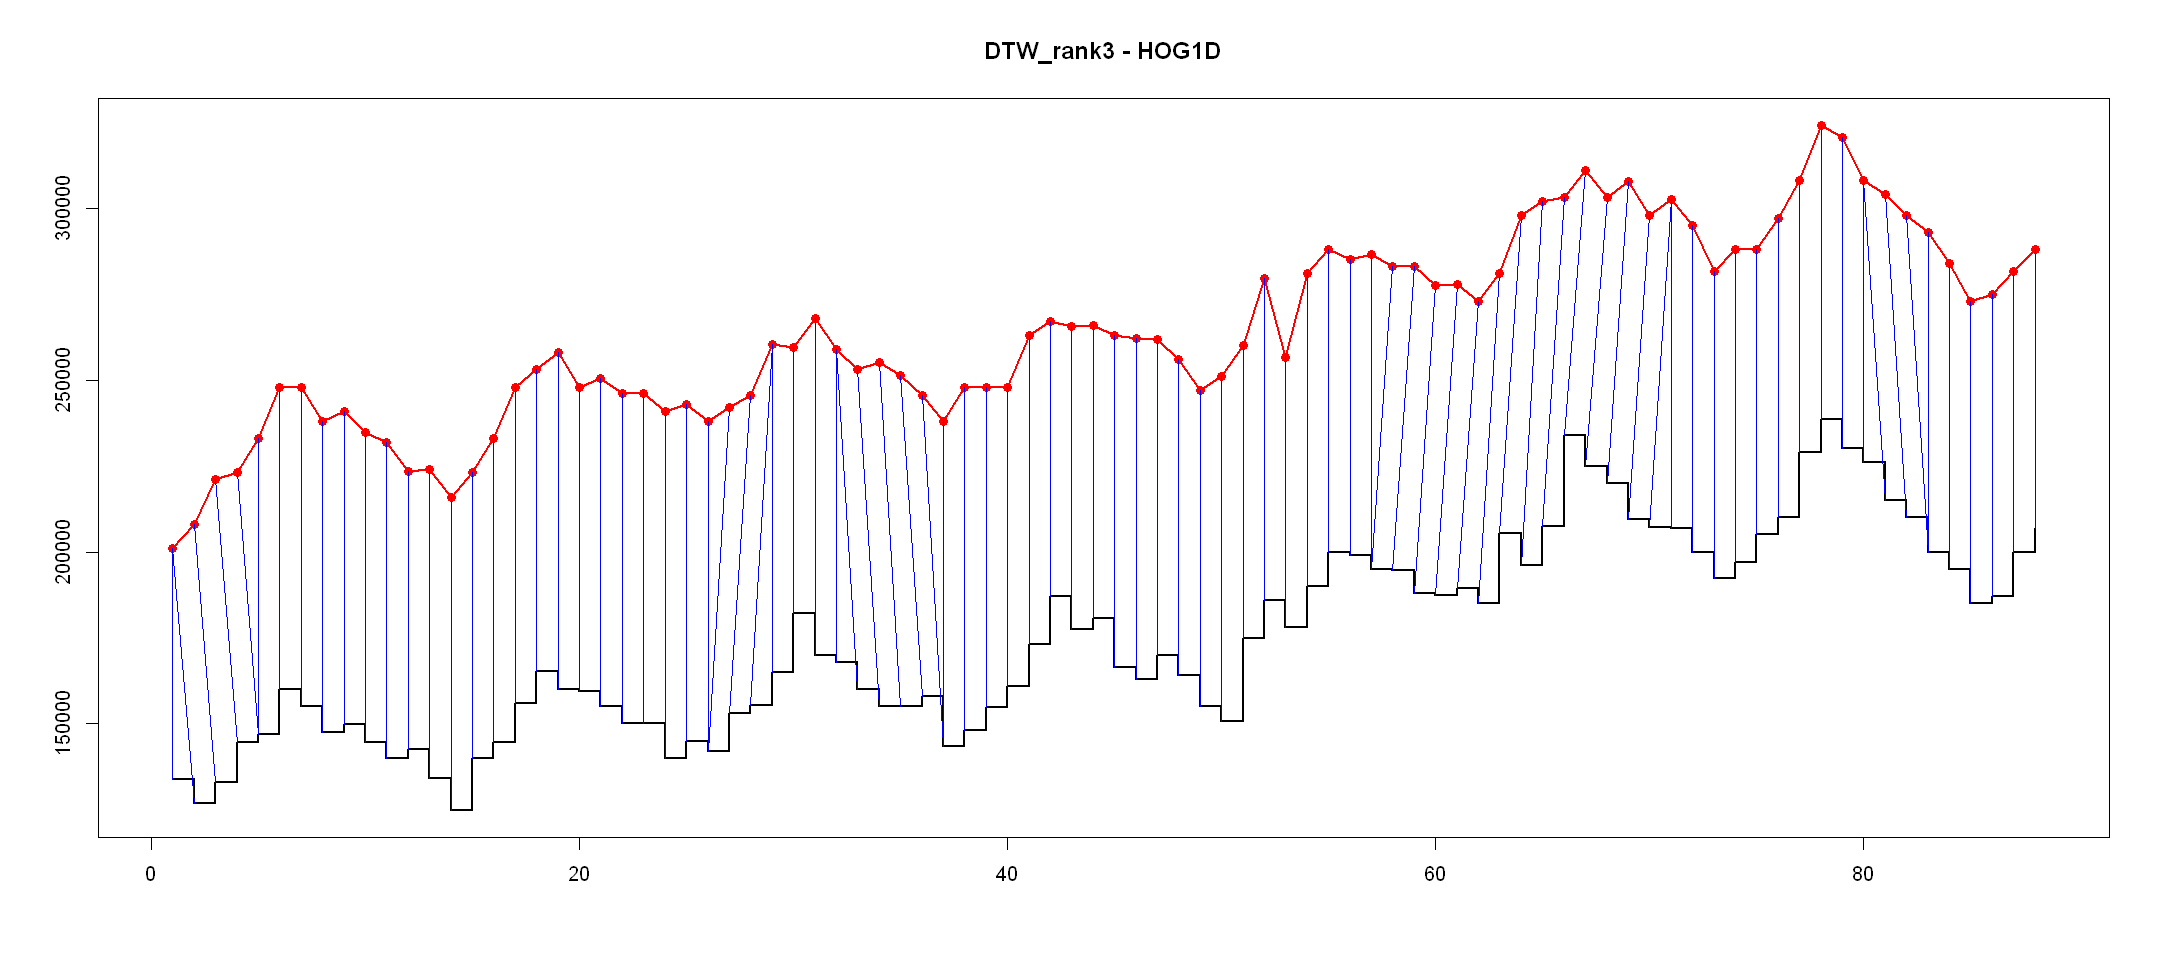

In [61]:
options(repr.plot.width = 18, repr.plot.height = 8)
metro_q <- 'Pittsburgh, PA metro area'
plotElasticMatching(dt_sel[region==metro_t]$median_sale_price, 
                    dt_sel[region==metro_q]$median_sale_price, 
                    metro_t_dist_results[[metro_q]]$match)
title("DTW_rank3 - HOG1D")

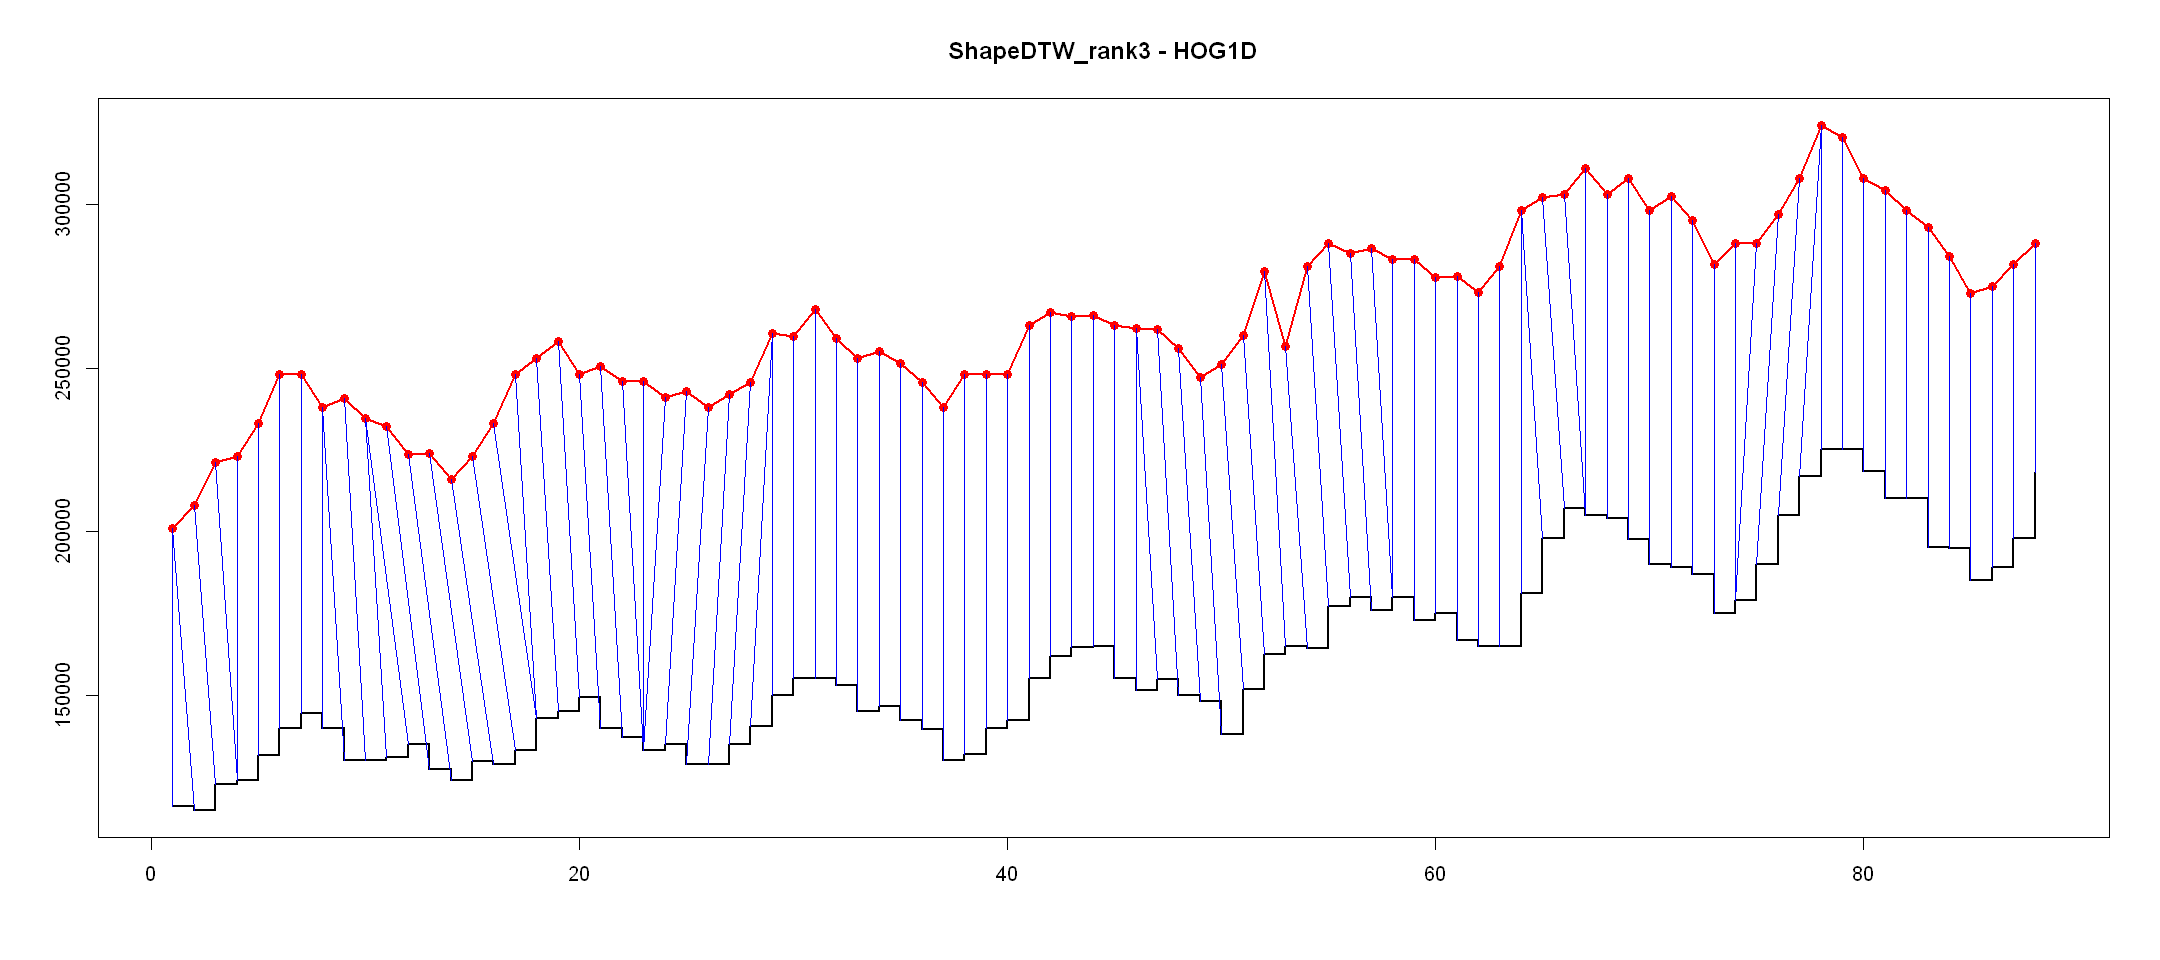

In [62]:
metro_q <- 'Rochester, NY metro area'
plotElasticMatching(dt_sel[region==metro_t]$median_sale_price, 
                    dt_sel[region==metro_q]$median_sale_price, 
                    metro_t_dist_results[[metro_q]]$match)
title("ShapeDTW_rank3 - HOG1D")

In [53]:
library(ggplot2)

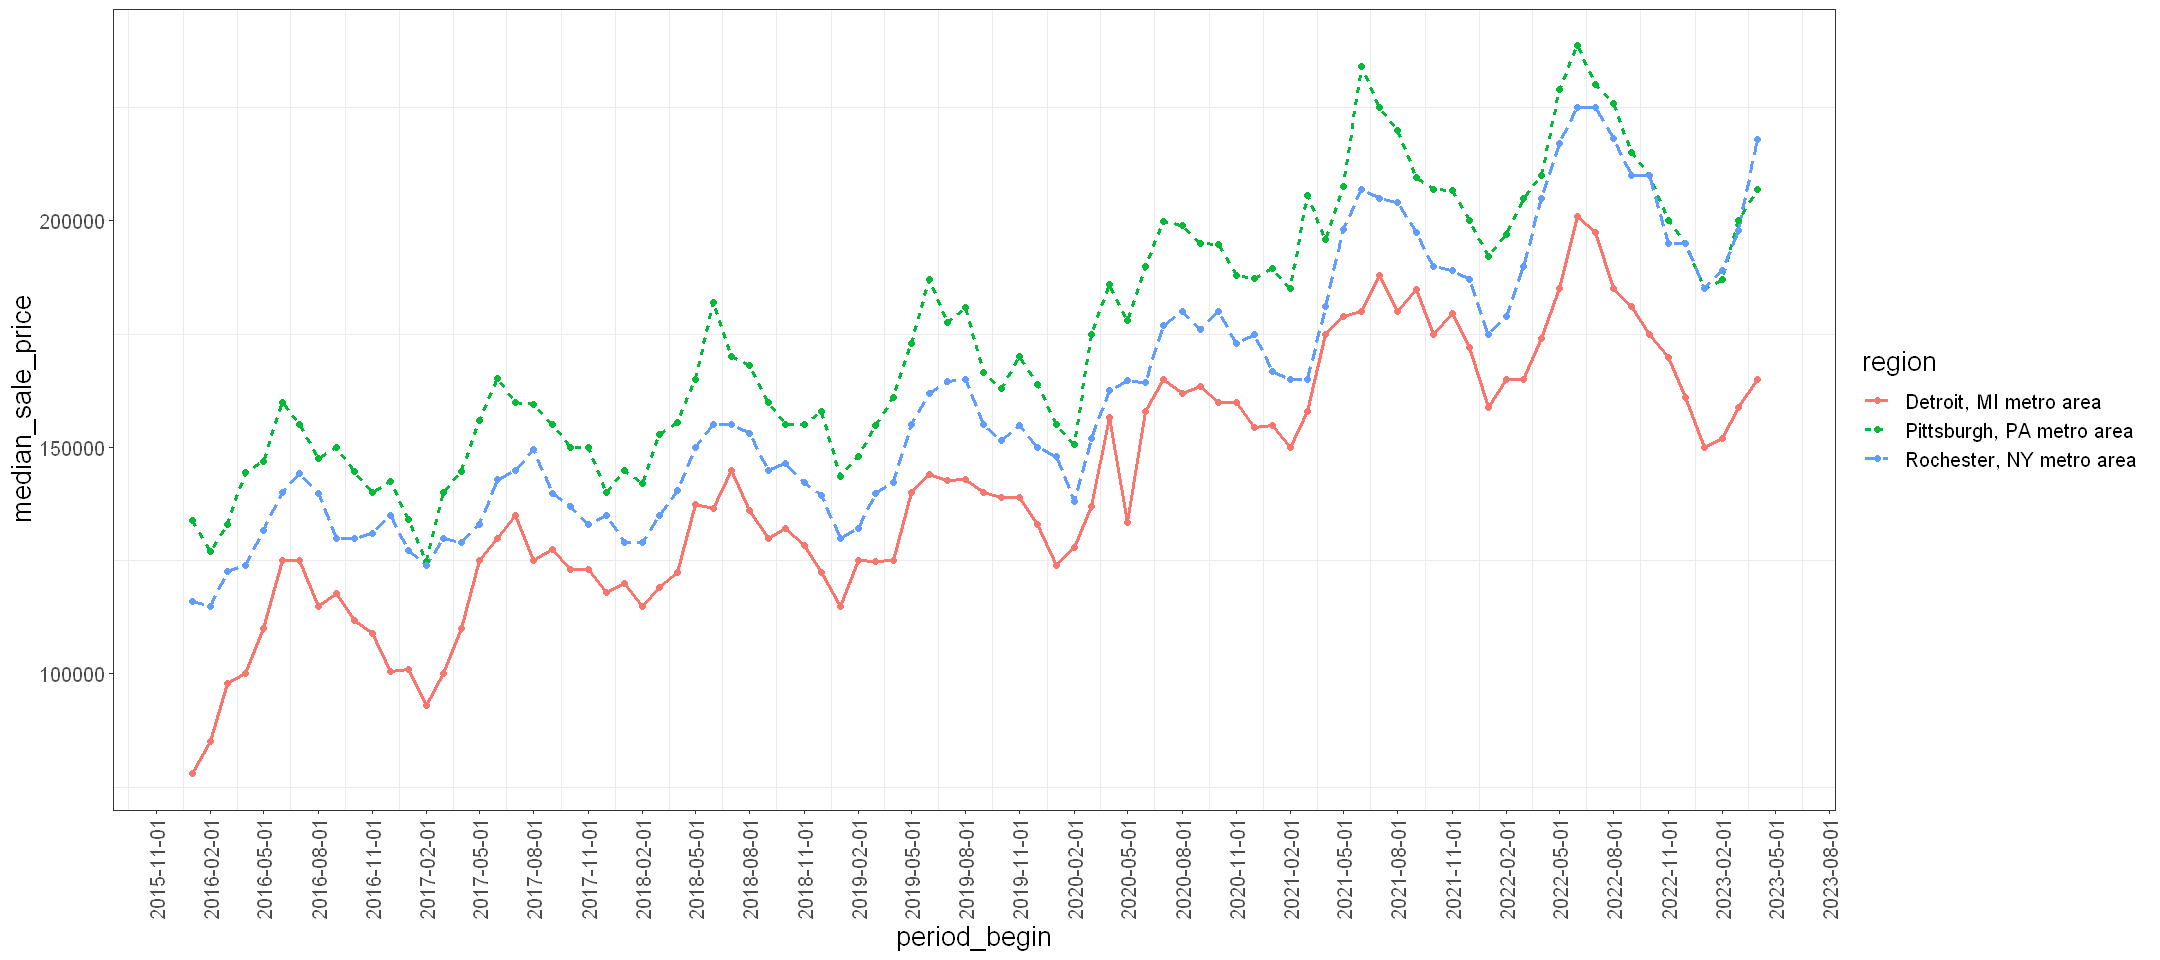

In [63]:
metro_sel <- c(metro_t, 'Pittsburgh, PA metro area', 'Rochester, NY metro area')
ggplot(data=dt_sel[region %in% metro_sel], aes(x=period_begin, y=median_sale_price, color=region)) + 
  geom_line(aes(linetype=region), size=1) +
  geom_point() +
  scale_x_date(breaks = "3 month") + 
  theme_bw() +
  theme(
    axis.text.x = element_text(angle = 90, vjust = 0.5, hjust = 1),
    axis.title = element_text(size = 16), axis.text = element_text(size = 12), 
    legend.title = element_text(size = 16), legend.text = element_text(size = 12),
    plot.background = element_blank(),
    panel.grid.major = element_blank()
  )